In [1]:
import pandas as pd
import numpy as np
from keras.layers import Dense, LSTM, Bidirectional, Dropout, Lambda
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler

df = pd.read_csv('weatherHistory.csv', parse_dates=['Formatted Date'])
df.head()

,Formatted Date,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars),Daily Summary
0,2006-04-01 00:00:00+02:00,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251.0,15.8263,0.0,1015.13,Partly cloudy throughout the day.
1,2006-04-01 01:00:00+02:00,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259.0,15.8263,0.0,1015.63,Partly cloudy throughout the day.
2,2006-04-01 02:00:00+02:00,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204.0,14.9569,0.0,1015.94,Partly cloudy throughout the day.
3,2006-04-01 03:00:00+02:00,Partly Cloudy,rain,8.288889,5.944444,0.83,14.1036,269.0,15.8263,0.0,1016.41,Partly cloudy throughout the day.
4,2006-04-01 04:00:00+02:00,Mostly Cloudy,rain,8.755556,6.977778,0.83,11.0446,259.0,15.8263,0.0,1016.51,Partly cloudy throughout the day.


In [2]:
df['Formatted Date'] = pd.to_datetime(df['Formatted Date'], utc=True)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96453 entries, 0 to 96452
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype              
---  ------                    --------------  -----              
 0   Formatted Date            96453 non-null  datetime64[ns, UTC]
 1   Summary                   96453 non-null  object             
 2   Precip Type               95936 non-null  object             
 3   Temperature (C)           96453 non-null  float64            
 4   Apparent Temperature (C)  96453 non-null  float64            
 5   Humidity                  96453 non-null  float64            
 6   Wind Speed (km/h)         96453 non-null  float64            
 7   Wind Bearing (degrees)    96453 non-null  float64            
 8   Visibility (km)           96453 non-null  float64            
 9   Loud Cover                96453 non-null  float64            
 10  Pressure (millibars)      96453 non-null  float64            
 11  Daily Summary  

**Data** **Cleaning**

In [4]:
df.isna().sum()

Formatted Date                0
Summary                       0
Precip Type                 517
Temperature (C)               0
Apparent Temperature (C)      0
Humidity                      0
Wind Speed (km/h)             0
Wind Bearing (degrees)        0
Visibility (km)               0
Loud Cover                    0
Pressure (millibars)          0
Daily Summary                 0
dtype: int64

In [5]:
df.shape

(96453, 12)

In [6]:
batas_mae = (df['Wind Speed (km/h)'].max() - df['Wind Speed (km/h)'].min()) * 0.1
batas_mae

6.385260000000001

**Mengambil 20.000 data dan membaginya untuk training dan validation**

In [7]:
df_train = df[1:16001]
df_val = df[16002:20002]

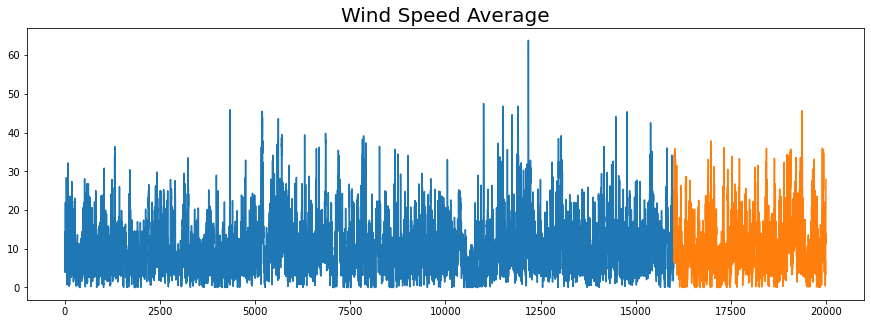

In [8]:
plt.figure(figsize=(15,5))
plt.plot(df_train.index, df_train[['Wind Speed (km/h)']])
plt.title('Wind Speed Average',
          fontsize=20);
plt.plot(df_val.index, df_val[['Wind Speed (km/h)']])
plt.title('Wind Speed Average',
          fontsize=20);

In [9]:
minmaxscaler = MinMaxScaler(feature_range = (0,1))
scale_train = minmaxscaler.fit_transform(df_train[['Wind Speed (km/h)']])
df_train[['Wind Speed (km/h)']] = scale_train

scale_val = minmaxscaler.fit_transform(df_val[['Wind Speed (km/h)']])
df_val[['Wind Speed (km/h)']] = scale_val

<ipython-input-9-285b3e30788c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train[['Wind Speed (km/h)']] = scale_train
C:\Users\welly\anaconda3\lib\site-packages\pandas\core\indexing.py:1736: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())
<ipython-input-9-285b3e30788c>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pan

In [10]:
date_train = df_train['Formatted Date']
wind_train  = df_train['Wind Speed (km/h)'].values

date_val = df_val['Formatted Date']
wind_val = df_val['Wind Speed (km/h)'].values

date_train.shape

(16000,)

In [11]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)


**Modelling**

In [12]:
train_set = windowed_dataset(wind_train, window_size=60, batch_size=100, shuffle_buffer=1000)
test_set  = windowed_dataset(wind_val, window_size=60, batch_size=100, shuffle_buffer=1000)
model = tf.keras.models.Sequential([
                                    tf.keras.layers.LSTM(64, return_sequences=True),
                                    tf.keras.layers.LSTM(64),
                                    tf.keras.layers.Dense(30, activation='relu'),
                                    tf.keras.layers.Dropout(0.2),
                                    tf.keras.layers.Dense(30, activation='relu'),
                                    tf.keras.layers.Dropout(0.5),
                                    tf.keras.layers.Dense(1)
])

**Membuat Class Callback**

In [13]:
from tensorflow.keras.callbacks import Callback
class myCallback(Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('mae')<0.09 and logs.get('val_mae')<0.09):
            print("MAE has reached below 10%")
            self.model.stop_training = True
callbacks = myCallback()

**Melatih Model**

In [14]:
optimizer = tf.keras.optimizers.SGD(learning_rate=1.0000e-04, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,
                    epochs=700,
                    callbacks=[callbacks],
                    validation_data=test_set)

Epoch 1/700
160/160 [==============================] - 58s 315ms/step - loss: 0.0164 - mae: 0.1461 - val_loss: 0.0315 - val_mae: 0.2002
Epoch 2/700
160/160 [==============================] - 53s 328ms/step - loss: 0.0110 - mae: 0.1101 - val_loss: 0.0249 - val_mae: 0.1700
Epoch 3/700
160/160 [==============================] - 39s 242ms/step - loss: 0.0086 - mae: 0.0949 - val_loss: 0.0212 - val_mae: 0.1542
Epoch 4/700
160/160 [==============================] - 38s 236ms/step - loss: 0.0074 - mae: 0.0880 - val_loss: 0.0189 - val_mae: 0.1450
Epoch 5/700
160/160 [==============================] - 37s 232ms/step - loss: 0.0068 - mae: 0.0848 - val_loss: 0.0175 - val_mae: 0.1390
Epoch 6/700
160/160 [==============================] - 38s 237ms/step - loss: 0.0065 - mae: 0.0838 - val_loss: 0.0167 - val_mae: 0.1353
Epoch 7/700
160/160 [==============================] - 37s 230ms/step - loss: 0.0064 - mae: 0.0832 - val_loss: 0.0161 - val_mae: 0.1330
Epoch 8/700
160/160 [===========================

In [15]:
model.evaluate(test_set)

40/40 [==============================] - 5s 108ms/step - loss: 0.0088 - mae: 0.0990


[0.008848241530358791, 0.0990009531378746]

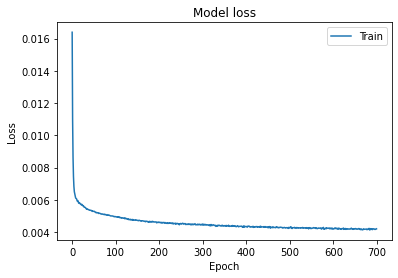

In [16]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper right')
plt.show()

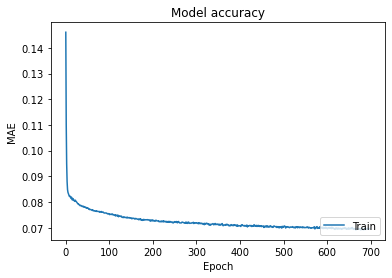

In [17]:
plt.plot(history.history['mae'])
plt.title('Model accuracy')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='lower right')
plt.show()